## Imports

In [1]:
# IMPORTS
# ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycountry
import rasterio
from scipy.spatial import cKDTree
from tqdm import tqdm
from datetime import datetime
import geopandas as gpd

import zipfile
import os
import gdown

# Contry data

In [2]:
country_info_path = (
    "https://drive.google.com/uc?id=1xfYlruvfAi6yieOd_S69pPYWphckRLr5&export=download"
)

column_names = [
    "Country_Code",  # Alpha-2 code
    "ISO_Alpha_3",  # Alpha-3 code
    "Numeric_Code",  # Numeric code
    "Alpha_2",  # Alpha-2 code (duplicate)
    "Country_Name",  # Name of the country
    "Capital",  # Capital city
    "Area",  # Area in square kilometers
    "Population",  # Population
    "Region",  # Region
    "TLD",  # Top-level domain
    "Currency_Code",  # Currency code
    "Currency_Name",  # Currency name
    "Currency_Numeric",  # Numeric currency code
    "Additional_Info",  # Additional information
]

country_info_df = pd.read_csv(
    country_info_path, delimiter="\t", comment="#", on_bad_lines="skip", header=None
)

country_info_df.columns = column_names
country_info_df.head()

,Country_Code,ISO_Alpha_3,Numeric_Code,Alpha_2,Country_Name,Capital,Area,Population,Region,TLD,Currency_Code,Currency_Name,Currency_Numeric,Additional_Info
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,77006,EU,.ad,EUR,Euro,376,AD
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,9630959,AS,.ae,AED,Dirham,971,NaN
2,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,NaN,.ai,XCD,Dollar,+1-264,AI-
3,AL,ALB,8,AL,Albania,Tirana,28748.0,2866376,EU,.al,ALL,Lek,355,NaN
4,AM,ARM,51,AM,Armenia,Yerevan,29800.0,2951776,AS,.am,AMD,Dram,374,NaN


## Countries 

In [3]:
countries_zip_url = "https://drive.google.com/uc?id=1UQzdO7suT0BnwKBeNybMG97vM9GIDogA"
countries_zip_file_path = "../../allCountries.zip"

# Download the ZIP file if it doesn't exist; otherwise, proceed to read the TXT file.
if not os.path.exists(countries_zip_file_path):
    gdown.download(countries_zip_url, countries_zip_file_path, quiet=False)

with zipfile.ZipFile(countries_zip_file_path) as z:
    countries_txt_filename = "allCountries.txt"

    with z.open(countries_txt_filename) as txt_file:
        countries_df = pd.read_csv(txt_file, sep="\t", header=None)


# https://download.geonames.org/export/dump/
countries_df.columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature class",
    "feature code",
    "iso alpha 2",
    "cc2",
    "admin1 code",
    "admin2 code",
    "admin3 code",
    "admin4 code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification date",
]

print(f"\nshape: {countries_df.shape}")
countries_df.head()

/var/folders/10/f1qn8xhx4sdfq2brlk2shcxw0000gn/T/ipykernel_73552/1495126749.py:12: DtypeWarning: Columns (9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  countries_df = pd.read_csv(txt_file, sep="\t", header=None)



shape: (12950185, 19)


,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
0,2994701,Roc Meler,Roc Meler,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74180,T,PK,AD,"AD,FR",02,NaN,NaN,NaN,0,2811.0,2348,Europe/Andorra,2023-10-03
1,3017832,Pic de les Abelletes,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,T,PK,AD,FR,A9,66,663.0,66146.0,0,NaN,2411,Europe/Andorra,2014-11-05
2,3017833,Estany de les Abelletes,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,H,LK,AD,FR,A9,NaN,NaN,NaN,0,NaN,2260,Europe/Andorra,2014-11-05
3,3023203,Port Vieux de la Coume d’Ose,Port Vieux de la Coume d'Ose,"Port Vieux de Coume d'Ose,Port Vieux de Coume ...",42.62568,1.61823,T,PASS,AD,NaN,00,NaN,NaN,NaN,0,NaN,2687,Europe/Andorra,2014-11-05
4,3029315,Port de la Cabanette,Port de la Cabanette,"Port de la Cabanette,Porteille de la Cabanette",42.60000,1.73333,T,PASS,AD,"AD,FR",B3,09,91.0,9139.0,0,NaN,2379,Europe/Andorra,2014-11-05


## EUI

In [4]:
eui_url = "https://drive.google.com/uc?id=12qGq_DLefI1RihIF_RKQUyJtm480-xRC"
eui_df = pd.read_csv(eui_url)

print(f"shape: {eui_df.shape}")
eui_df.head()

shape: (482, 5)


,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year)
0,Nha Trang,1572151,Vietnam,59.096065,112.778867
1,Aberdeen,2657832,United Kingdom,231.302877,259.832393
2,Abidjan,2293538,Cote d'Ivoire,73.830819,105.622137
3,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457
4,Abuja,2352778,Nigeria,63.955819,103.009079


In [5]:
merged_df = pd.merge(
    countries_df, eui_df, left_on="geonameid", right_on="Geonames ID", how="inner"
)
assert merged_df.shape[0] == eui_df.shape[0]
print(f"shape: {merged_df.shape}")
merged_df.head()

shape: (482, 24)


,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,population,elevation,dem,timezone,modification date,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year)
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,1807000,NaN,6,Asia/Dubai,2024-03-27,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,4434550,NaN,1798,Asia/Kabul,2024-09-05,Kabul,1138958,Afghanistan,213.167026,144.395840
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,418495,NaN,113,Europe/Tirane,2023-01-01,Tirana,3183875,Albania,133.717672,101.873579
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,1093485,NaN,994,Asia/Yerevan,2023-11-13,Yerevan,616052,Armenia,198.865302,132.124738
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,2776168,NaN,73,Africa/Luanda,2024-03-26,Luanda,2240449,Angola,65.343750,104.311100


## Adding ISO 3 Code

In [6]:
# Adding ISO CODE 3
alpha_2_to_alpha_3 = {
    country.alpha_2: country.alpha_3 for country in pycountry.countries
}
merged_df.loc[:, "ISO_alpha3"] = merged_df["iso alpha 2"].map(alpha_2_to_alpha_3)

# Manually correcting the missing country code for Namibia by assigning 'NAM' because country code is null for Nambia
merged_df.loc[merged_df["Country"] == "Namibia", "ISO_alpha3"] = "NAM"
merged_df.loc[merged_df["Country"] == "Namibia", "iso alpha 2"] = "NA"

print(f"shape: {merged_df.shape}")

assert (
    merged_df["ISO_alpha3"].isna().sum() == 0
), "There are missing values in the ISO_alpha3 column."
assert merged_df.shape[0] == 482, "The number of rows in merged_df is not 482."

shape: (482, 25)


# Temperature

In [1]:
# A function to retrive multipal days and hours temp data from API

import cdsapi
from datetime import datetime, timedelta
import time


def download_temperature_data(
    start_date_str, end_date_str, hours, api_key=None, rate_limit_seconds=1
):
    """
    Download temperature data (2m temperature) for multiple days and hours using the CDS API.

    Args:
    - start_date_str (str): Start date in 'YYYY-MM-DD' format.
    - end_date_str (str): End date in 'YYYY-MM-DD' format.
    - hours (list): List of hours to download data for (e.g., ['00:00', '03:00', '06:00']).
    - api_key (str, optional): API key if needed. Default is None.
    - rate_limit_seconds (int): Time to wait between API requests to avoid hitting rate limits. Default is 1 second.

    Returns:
    - None. Data will be downloaded and saved as .nc files for each day.
    """

    # Initialize the CDS API client
    c = cdsapi.Client(
        url="https://cds-beta.climate.copernicus.eu/api",
        key="384d14bf-681e-44c7-9f2b-4f12ebb18f12",
    )

    # Parse the start and end dates
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    # Loop through the date range
    current_date = start_date

    while current_date <= end_date:
        try:
            # Format the date strings for the API request
            year = current_date.strftime("%Y")
            month = current_date.strftime("%m")
            day = current_date.strftime("%d")

            # Log start time for download
            start_time = time.time()

            # Request data from the API
            print(
                f"Requesting data for {current_date.strftime('%Y-%m-%d')} at times: {hours}"
            )
            c.retrieve(
                "reanalysis-era5-single-levels",
                {
                    "product_type": "reanalysis",
                    "format": "netcdf",
                    "variable": "2m_temperature",
                    "year": year,
                    "month": month,
                    "day": day,
                    "time": hours,  # List of hours to query
                },
                f"download_{year}{month}{day}.nc",  # Save with unique filename
            )

            # Log end time for download
            end_time = time.time()
            print(
                f"Download for {year}-{month}-{day} took {end_time - start_time:.2f} seconds."
            )

            # Move to the next day
            current_date += timedelta(days=1)

            # Sleep to avoid rate limits
            time.sleep(rate_limit_seconds)

        except Exception as e:
            print(
                f"Failed to download data for {current_date.strftime('%Y-%m-%d')}: {e}"
            )
            current_date += timedelta(
                days=1
            )  # Move to the next day even if there's an error

    print("Data download completed.")


# Example usage:
start_date = "2023-12-01"  # Start date
end_date = "2023-12-31"  # End date
hours = [
    "00:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
]  # List of hours to query

# Call the function to download data
download_temperature_data(start_date, end_date, hours, rate_limit_seconds=2)

2024-11-13 23:05:08,012 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-13 23:05:08,013 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-13 23:05:08,013 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-13 23:05:08,014 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

Requesting data for 2024-01-01 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-13 23:05:08,844 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-13 23:05:08,846 INFO Request ID is 68faf265-0fed-4664-a975-767d3ad6a959
2024-11-13 23:05:09,564 INFO status has been updated to accepted
2024-11-13 23:05:13,843 INFO status has been updated to running
2024-11-13 23:05:22,997 INFO status has been updated to successful


9413847e39e00dd3b71a1a90865fbbc1.nc:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Download for 2024-01-01 took 20.26 seconds.
Data download completed.


In [209]:
# Compile daily data into montly file
import xarray as xr
import os
import calendar

data_dir = "../notebooks"
# Define the year for which you want to combine the files
year = 2023
month = 12
days_in_month = calendar.monthrange(year, month)[1]

file_list = []

for day in range(1, 32):  # Loop over the days (1 to 31)
    try:
        for day in range(1, days_in_month + 1):
            file_name = f"download_{year:04d}{month:02d}{day:02d}.nc"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            file_list.append(file_path)
    except ValueError:
        continue  # Skip invalid days (like 30th in February)

# Open all files and combine them into a single dataset
ds_list = [xr.open_dataset(file) for file in file_list]

# Combine datasets along the time dimension (or other appropriate dimensions)
combined_ds = xr.concat(ds_list, dim="time")  # Adjust dimension as needed

# Save the combined dataset to a single NetCDF file
combined_ds.to_netcdf(f"combined_{year}{month}.nc")

# Close all datasets
for ds in ds_list:
    ds.close()

In [7]:
# iteratively caculate hdd for compiled month data
import numpy as np
import rasterio
from tqdm import tqdm
from datetime import datetime

temp_thresh = 18
file_template = "../notebooks/combined_2023{}.nc"


def get_cdd(temperature, temp_thresh):
    keep = temperature > temp_thresh
    cdd = np.zeros(temperature.shape)
    cdd[keep] = temperature[keep] - temp_thresh
    return cdd / 24  # Convert from heating degree hours to degree days


# Placeholder arrays for latitude, longitude, and HDD results for each month
cdd_flat_dict = {}

# Loop over each month
for month in range(1, 13):
    file_path = file_template.format(f"{month}")

    with rasterio.open(file_path) as src:
        celsius_factor = -273.15
        temp_conversion = lambda x: x + celsius_factor

        n_lon = src.width
        n_lat = src.height
        left = src.bounds.left
        right = src.bounds.right
        bottom = src.bounds.bottom
        top = src.bounds.top

        # Initialize the HDD accumulator for this month
        monthly_hdd = np.zeros((n_lat, n_lon))

        for i in tqdm(src.indexes, desc=f"Processing month {month}"):
            # Read the data for the current timepoint
            raw_data = src.read(i)

            # Convert temperature data to Celsius
            temperature = temp_conversion(raw_data)

            # Compute the HDDs for this timepoint
            chdd = get_cdd(temperature, temp_thresh)

            # Accumulate HDDs for the entire month
            monthly_hdd += chdd

        # Flatten the HDD data for this month and store in the dictionary
        cdd_flat_dict[f"cdd_flat_{month}"] = monthly_hdd.ravel()

# Prepare latitude and longitude grids for the spatial coordinates
lon_arr = np.linspace(left, right, n_lon)
lat_arr = np.linspace(bottom, top, n_lat)
lon_grid, lat_grid = np.meshgrid(lon_arr, lat_arr)
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()

Processing month 12: 100%|██████████| 248/248 [00:31<00:00,  7.92it/s]


In [8]:
# check in monthly hdd data
cdd_flat_dict
for month in range(1, 13):
    cdd_flat = cdd_flat_dict[f"cdd_flat_{month}"]
    print(
        f"Month {month}: Min CDD = {cdd_flat.min()}, Max CDD = {cdd_flat.max()}, Mean CDD = {cdd_flat.mean()}, Total CDD = {cdd_flat.sum()}"
    )

Month 1: Min CDD = 0.0, Max CDD = 175.72603098551429, Mean CDD = 24.034869107429962, Total CDD = 24953962.502098083
Month 2: Min CDD = 0.0, Max CDD = 189.14059321085608, Mean CDD = 26.24986885514349, Total CDD = 27253663.840164177
Month 3: Min CDD = 0.0, Max CDD = 190.6572608947754, Mean CDD = 26.20453161396366, Total CDD = 27206592.90288163
Month 4: Min CDD = 0.0, Max CDD = 201.87881215413418, Mean CDD = 27.29175839516478, Total CDD = 28335395.23619588
Month 5: Min CDD = 0.0, Max CDD = 230.98069127400697, Mean CDD = 29.056173135662707, Total CDD = 30167281.19637045
Month 6: Min CDD = 0.0, Max CDD = 276.1382535298666, Mean CDD = 31.138607800444714, Total CDD = 32329348.16273372
Month 7: Min CDD = 0.0, Max CDD = 258.37629954020133, Mean CDD = 33.409542363119975, Total CDD = 34687123.263085686
Month 8: Min CDD = 0.0, Max CDD = 235.99220657348602, Mean CDD = 31.42531630599995, Total CDD = 32627020.401541386
Month 9: Min CDD = 0.0, Max CDD = 208.69159698486305, Mean CDD = 30.12852789653788

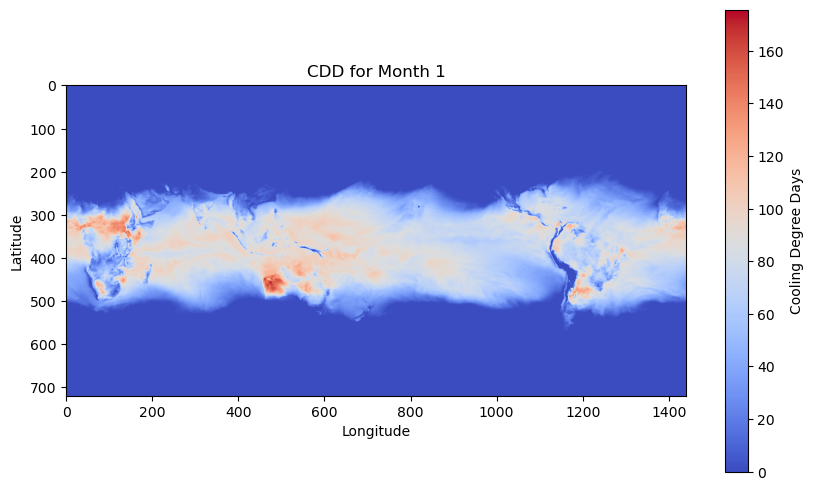

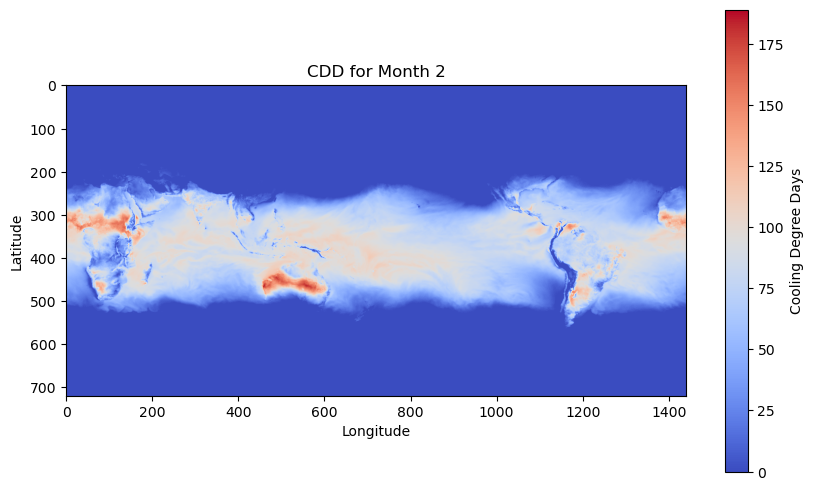

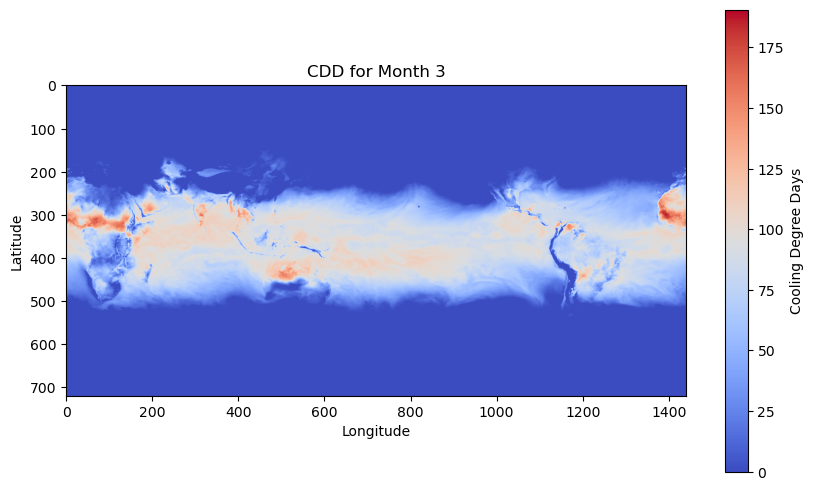

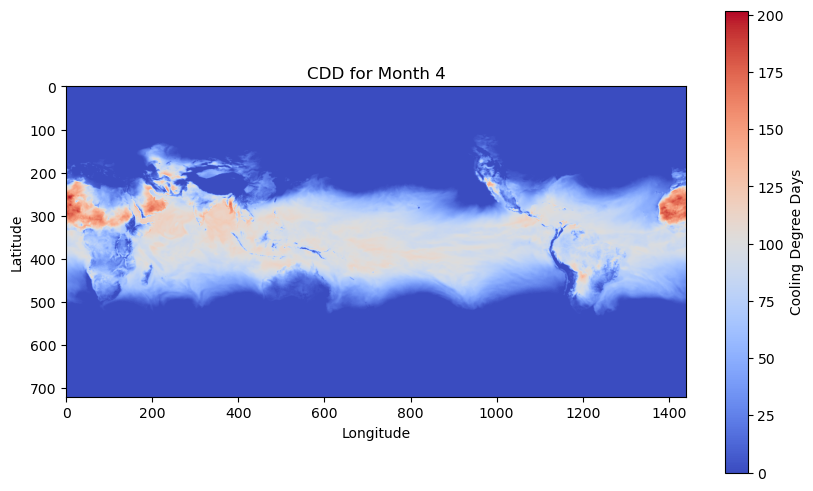

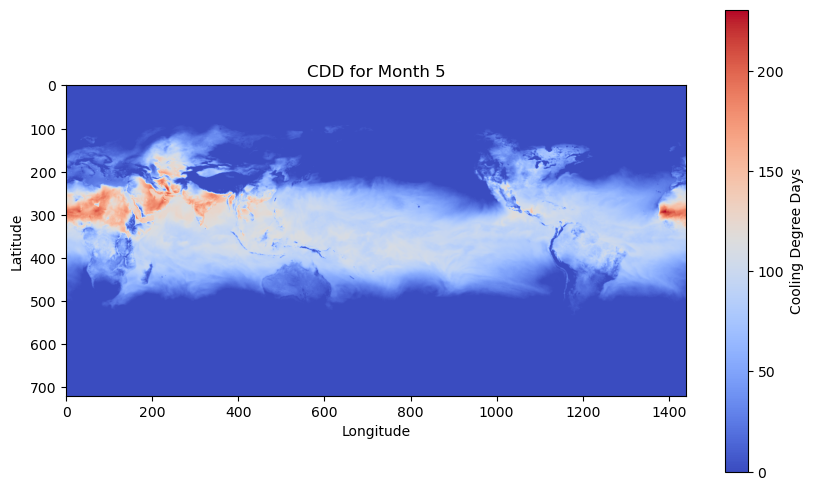

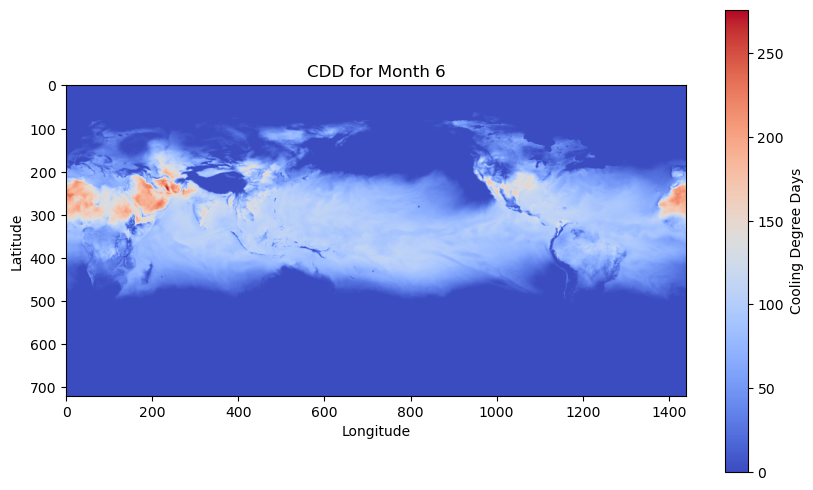

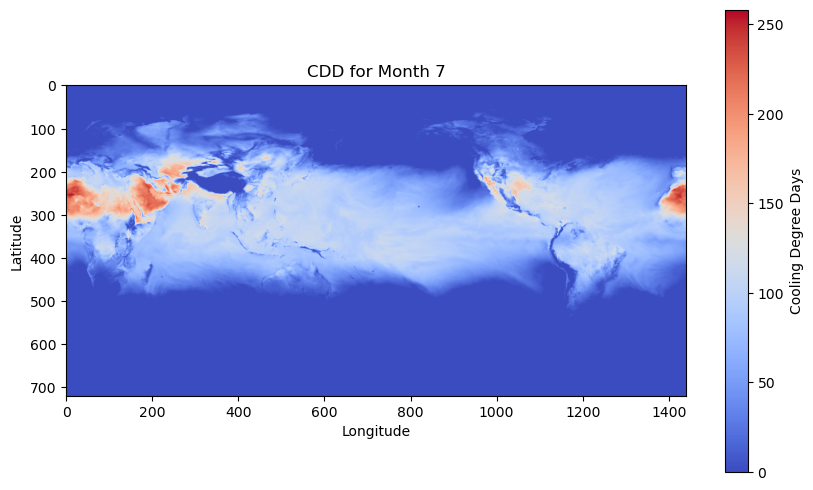

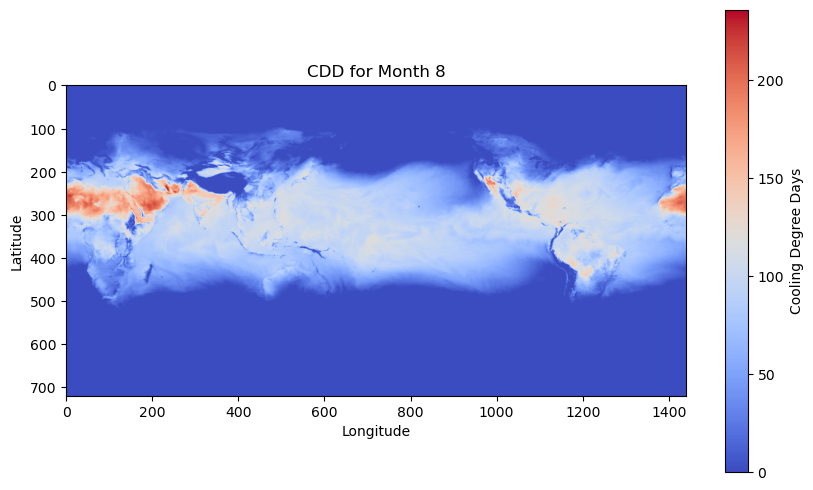

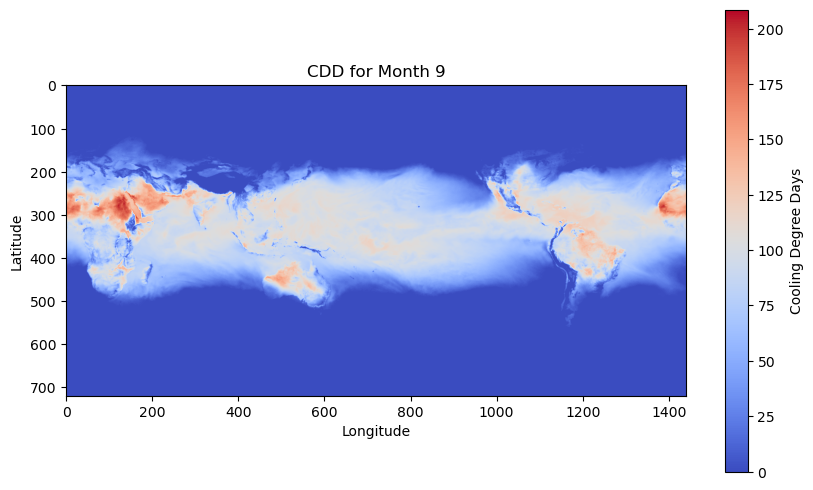

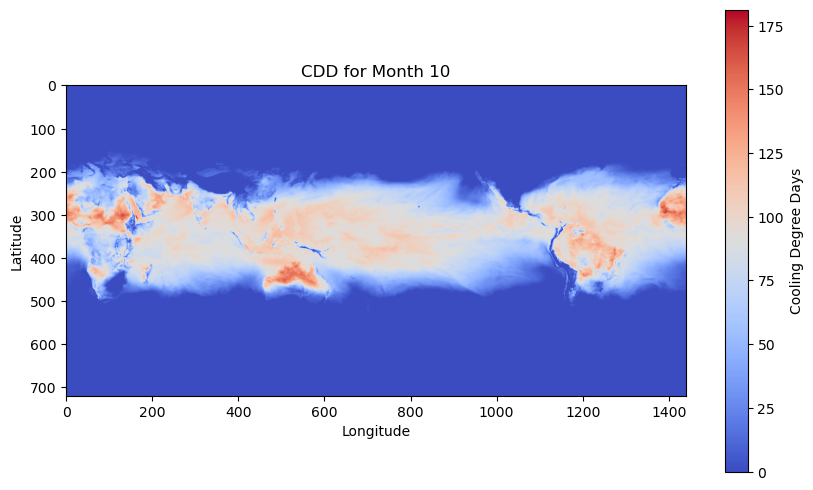

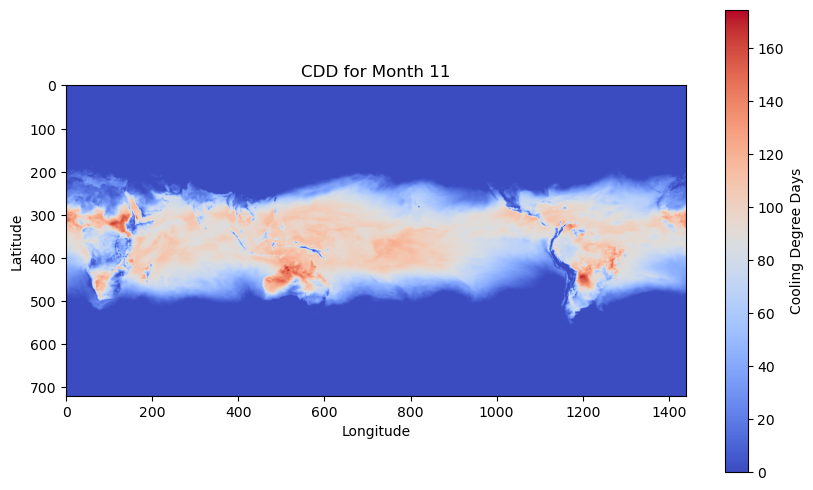

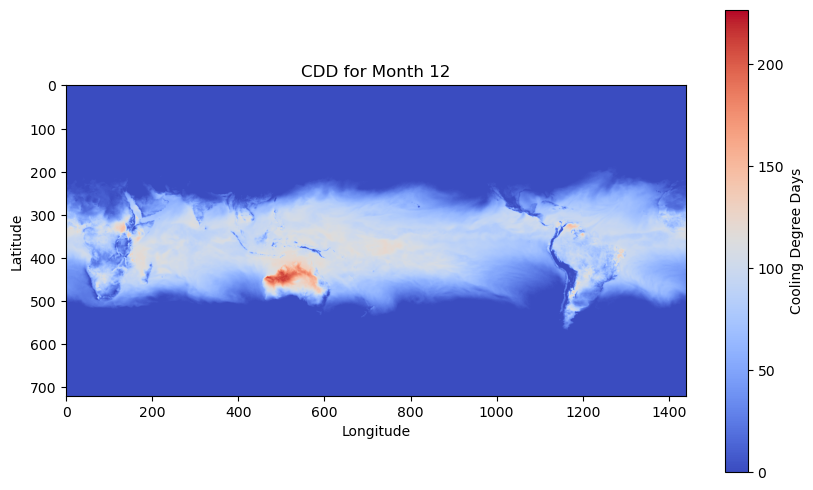

In [9]:
# visualization of hdd monthly
import matplotlib.pyplot as plt

for month in range(1, 13):
    cdd_flat = cdd_flat_dict[f"cdd_flat_{month}"]
    cdd_2d = cdd_flat.reshape(n_lat, n_lon)

    plt.figure(figsize=(10, 6))
    plt.imshow(cdd_2d, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Cooling Degree Days")
    plt.title(f"CDD for Month {month}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [10]:
# merge hdd monthly data into main table ---merged_df
from tqdm import tqdm

for i in range(1, 13):
    merged_df[f"nearest_cdd_{i}"] = np.nan
latitude = merged_df["latitude"]
longitude = merged_df["longitude"]
lon_flat = np.where(
    lon_flat > 180, lon_flat - 360, lon_flat
)  # convert scale from 0-360 to -180 180.
tree = cKDTree(np.column_stack((lat_flat, lon_flat)))

for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0]):
    latitude = row["latitude"]
    longitude = row["longitude"]

    dist, idx = tree.query([latitude, longitude])
    for month in range(1, 13):
        cdd_flat = cdd_flat_dict[f"cdd_flat_{month}"]
        merged_df.at[index, f"nearest_cdd_{month}"] = cdd_flat[idx]

100%|██████████| 482/482 [00:00<00:00, 8039.25it/s]


In [12]:
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_cdd_3,nearest_cdd_4,nearest_cdd_5,nearest_cdd_6,nearest_cdd_7,nearest_cdd_8,nearest_cdd_9,nearest_cdd_10,nearest_cdd_11,nearest_cdd_12
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,76.440627,65.835030,43.656228,31.195871,41.757240,32.917988,54.085152,68.196161,78.517668,75.547442
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,12.982456,0.000000,0.073516,0.000000,0.000000,0.000000,0.000000,0.000000,0.977383,4.599513
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,164.319370,123.538724,107.409565,102.194650,89.934893,95.442727,91.207954,118.046421,118.561858,87.096759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,7.160732,34.061598,147.943175,121.377918,138.410235,144.420104,111.718208,58.629754,7.532686,5.040843
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,0.000000,2.100417,27.187478,69.612863,107.770994,92.629821,50.686958,54.913690,21.956796,0.100241
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,46.598586,110.808744,149.330708,156.954253,162.376706,143.181416,166.942004,142.636021,61.724386,21.796323
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,53.981008,113.187731,160.365376,181.223459,193.641599,176.134052,192.853544,138.758498,96.136809,37.425222


In [15]:
# visualize hdd in html

import folium
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors


# Create a map centered around the average latitude and longitude
map_center = folium.Map(
    location=[merged_df["latitude"].mean(), merged_df["longitude"].mean()],
    zoom_start=10,
)

# Normalize HDD values to map colors
norm = colors.Normalize(
    vmin=merged_df["nearest_cdd_12"].min(), vmax=merged_df["nearest_cdd_12"].max()
)
colormap = cm.ScalarMappable(
    norm=norm, cmap="YlOrRd"
)  # Use a yellow-orange-red color map

# Add CircleMarkers with color gradient based on HDD
for _, row in merged_df.iterrows():
    color = colors.to_hex(
        colormap.to_rgba(row["nearest_cdd_12"])
    )  # Convert to hex for folium
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"HDD: {row['nearest_cdd_12']}",
        tooltip="Click for HDD value",
    ).add_to(map_center)

# Display the map
map_center.save("cdd_color_map_12.html")
import webbrowser

webbrowser.open("file://" + os.path.realpath("cdd_color_map_12.html"))

True

In [16]:
# caculate yearly total hdd and add monthly average and variance
import numpy as np

merged_df["total_year"] = merged_df[[f"nearest_cdd_{i}" for i in range(1, 13)]].sum(
    axis=1
)

merged_df["average_year"] = merged_df[[f"nearest_cdd_{i}" for i in range(1, 13)]].mean(
    axis=1
)

merged_df["variance_year"] = merged_df[[f"nearest_cdd_{i}" for i in range(1, 13)]].var(
    axis=1
)

In [17]:
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_cdd_6,nearest_cdd_7,nearest_cdd_8,nearest_cdd_9,nearest_cdd_10,nearest_cdd_11,nearest_cdd_12,total_year,average_year,variance_year
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,31.195871,41.757240,32.917988,54.085152,68.196161,78.517668,75.547442,727.058267,60.588189,355.189544
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.977383,4.599513,97.660217,8.138351,228.965907
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.002186,0.166849,0.208624
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.010466,1.667539,33.368230
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,102.194650,89.934893,95.442727,91.207954,118.046421,118.561858,87.096759,1393.447264,116.120605,662.397738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,121.377918,138.410235,144.420104,111.718208,58.629754,7.532686,5.040843,809.565919,67.463827,3666.990016
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,69.612863,107.770994,92.629821,50.686958,54.913690,21.956796,0.100241,426.959258,35.579938,1514.545468
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,156.954253,162.376706,143.181416,166.942004,142.636021,61.724386,21.796323,1286.950672,107.245889,2783.939088
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,181.223459,193.641599,176.134052,192.853544,138.758498,96.136809,37.425222,1498.054211,124.837851,3189.976365


In [18]:
output_path = "../data/processed"
os.makedirs(output_path, exist_ok=True)

merged_df.to_csv(
    os.path.join(output_path, "merged_df_CDD_scalematched.csv"), index=False
)